In [1]:
import os, sys
import numpy as np
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

sys.path.append("../../src")
from explainer import Archipelago
from application_utils.rec_utils import get_autoint_and_data, AutoIntWrapper, IdXformer
from application_utils.rec_utils import get_example, evaluate, get_avazu_dict
from viz.rec import viz_bar_chart

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Get Model and Data

In [2]:
model, data = get_autoint_and_data(dataset="Avazu",
    data_path="../../downloads/avazu_data/avazu_val_minibatch.pickle",
    save_path="../../downloads/pretrained_autoint/",
    feature_size = 1544489)

total parameters :25059714
extra parameters : 347890
restored from ../../downloads/pretrained_autoint/


## Get Example and Classification

In [3]:
for index in range(len(data["Xi"])):
    Xv_inst, Xi_inst = get_example(data, index=index)
    model_wrapper = AutoIntWrapper(model, Xi_inst, inv_sigmoid=True)

    pred = model_wrapper(Xv_inst)

    outcome = "click" if pred>0 else "not click"
    if outcome == "click":
        print(outcome)
        print(index)
        break

click
108


In [4]:
model_wrapper(Xv_inst).item(),model_wrapper(np.zeros_like(Xv_inst)).item()

(0.2508336305618286, -0.9878369569778442)

## Explain Prediction

In [5]:
xf = IdXformer(Xv_inst, np.zeros_like(Xv_inst))
apgo = Archipelago(model_wrapper, data_xformer=xf, output_indices=0, batch_size=20)

In [6]:
explanation = apgo.explain(top_k=3)

### Show Result

In [7]:
sorted_sets = sorted(explanation.items(), key=lambda item: -item[1])

avazu_dict = get_avazu_dict()
sorted_labels = []
for s, v in sorted_sets:
    labels = [avazu_dict[i] for i in s]
    if len(labels) == 1:
        if labels[0].startswith("C"): #anonymous feature
            continue
            
    labels = r", ".join(labels)
    sorted_labels.append( (labels, v) )

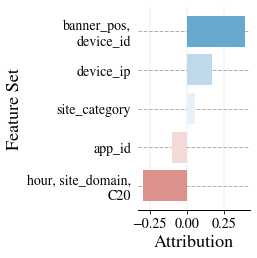

In [8]:
viz_bar_chart(sorted_labels, top_k=5, figsize=(2.,3.75), save_file=None, max_label_size=18, remove_space=False)